In [1]:
from fastai.vision.all import *

# Foundations of computer vision

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#3) [Path('/storage/data/mnist_sample/labels.csv'),Path('/storage/data/mnist_sample/valid'),Path('/storage/data/mnist_sample/train')]

In [3]:
(path/'train').ls()

(#2) [Path('/storage/data/mnist_sample/train/7'),Path('/storage/data/mnist_sample/train/3')]

This dataset only contains the subset of '3' and '7' from the original MNIST dataset.

In [4]:
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()
threes

(#6131) [Path('/storage/data/mnist_sample/train/3/10.png'),Path('/storage/data/mnist_sample/train/3/10000.png'),Path('/storage/data/mnist_sample/train/3/10011.png'),Path('/storage/data/mnist_sample/train/3/10031.png'),Path('/storage/data/mnist_sample/train/3/10034.png'),Path('/storage/data/mnist_sample/train/3/10042.png'),Path('/storage/data/mnist_sample/train/3/10052.png'),Path('/storage/data/mnist_sample/train/3/1007.png'),Path('/storage/data/mnist_sample/train/3/10074.png'),Path('/storage/data/mnist_sample/train/3/10091.png')...]

## How are images stored

In [5]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [6]:
np.array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [7]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties().background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Simple model 1: Pixel similiarity

In [8]:
three_tensors = [tensor(Image.open(path)) for path in threes]
seven_tensors = [tensor(Image.open(path)) for path in sevens]

In [9]:
len(three_tensors), len(seven_tensors)

(6131, 6265)

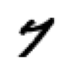

In [10]:
show_image(seven_tensors[1], cmap='gray_r');

Computing the mean value for each pixel:

In [11]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

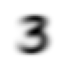

In [12]:
mean3 = stacked_threes.mean(0)
show_image(mean3, cmap='gray_r');

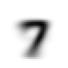

In [13]:
mean7 = stacked_sevens.mean(0)
show_image(mean7, cmap='gray_r');

#### Distance to ideal number

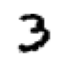

In [14]:
sample_3 = three_tensors[4].float()/255
show_image(sample_3, cmap='gray_r');

In [15]:
diff3 = ((mean3 - sample_3)**2).mean()
diff7 = ((mean7 - sample_3)**2).mean()
diff3, diff7

(tensor(0.0561), tensor(0.0977))

These loss functions are bundled in pytorchs nn.functional module:
- mse_loss
- l1_loss

In [16]:
F.mse_loss(sample_3, mean3), F.mse_loss(sample_3, mean7)

(tensor(0.0561), tensor(0.0977))

#### Validation loss

In [17]:
valid_threes = (path/'valid/3').ls().sorted()
valid_sevens = (path/'valid/7').ls().sorted()

In [18]:
%%time
three_tensors = [tensor(Image.open(path)) for path in valid_threes]
seven_tensors = [tensor(Image.open(path)) for path in valid_sevens]

CPU times: user 860 ms, sys: 147 ms, total: 1.01 s
Wall time: 4.82 s


In [19]:
valid_stacked_sevens = torch.stack(seven_tensors).float()/255
valid_stacked_threes = torch.stack(three_tensors).float()/255

In [20]:
valid_stacked_sevens.shape

torch.Size([1028, 28, 28])

In [21]:
def diff_to(stack, mean):
    return (stack - mean).abs().mean(dim=[1,2])

In [22]:
correct_sevens = (diff_to(valid_stacked_sevens, mean3) > diff_to(valid_stacked_sevens, mean7)).sum().item()
correct_threes = (diff_to(valid_stacked_threes, mean3) < diff_to(valid_stacked_threes, mean7)).sum().item()

total_correct = correct_sevens + correct_threes
total = len(valid_threes) + len(valid_sevens)

print('Correct sevens: ', correct_sevens)
print('Correct threes: ', correct_threes)
print('Total: ', total_correct/total)

Correct sevens:  1013
Correct threes:  926
Total:  0.9514229636898921


# Stochastic Gradient Descent (SGD)

In [23]:
from fastbook import *

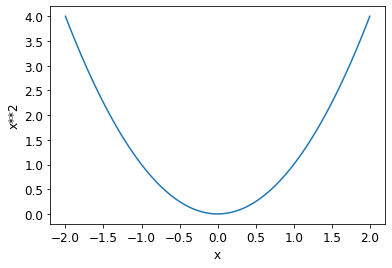

In [24]:
def f(x): return x**2
plot_function(f, 'x', 'x**2')

Starting with a random initialization:

In [25]:
current_x = -1.5

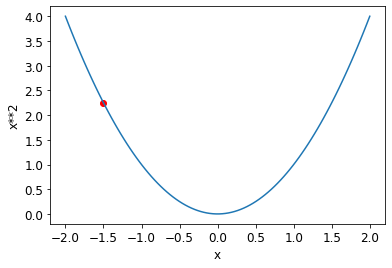

In [26]:
plot_function(f, 'x', 'x**2')
plt.scatter(current_x, f(current_x), color='red');

Gradients are directly done with pytorch magic:

In [27]:
xt = tensor(3.).requires_grad_()
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [28]:
# calculate the gradient wrt. all saved computations
yt.backward()

In [29]:
xt.grad

tensor(6.)

##### Demonstration for tensor input:

In [30]:
def f(x):
    return (x**2).sum()

In [31]:
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [32]:
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [33]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

##### Simple SGD example

In [34]:
def loss(x):
    return (x**2)

lr = .1
xt = tensor(-1.5).requires_grad_()
xt

tensor(-1.5000, requires_grad=True)

In [35]:
steps = []
for _ in range(10):
    xt.grad = None
    yt = loss(xt)
    yt.backward()
    xt.data -= xt.grad*lr
    steps.append(xt.item())
steps = tensor(steps)

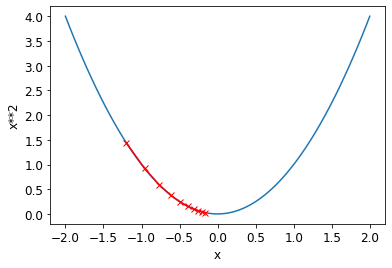

In [36]:
plot_function(loss, 'x', 'x**2')
plt.plot(steps, loss(steps), color='red', marker='x');

##### Slightly more complicated SGD example

###### Dataset

In [37]:
time = torch.arange(0, 20).float()
speed = torch.randn(20)*3 + .75*(time-9.5)**2 + 1

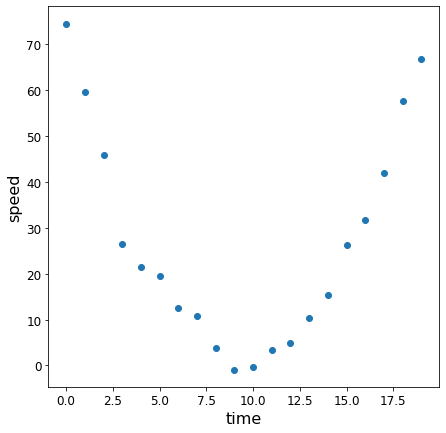

In [38]:
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(time, speed)
ax.set_xlabel('time', fontsize=16)
ax.set_ylabel('speed', fontsize=16)

plt.show()

###### Model function

In [39]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + b*t + c

###### Loss function

In [40]:
def mse(actual, expected):
    return ((actual-expected)**2).mean()

###### Initializing the parameters

In [41]:
params = torch.randn(3).requires_grad_()

###### Calculate the predictions

In [42]:
preds = f(time, params)
preds.shape

torch.Size([20])

In [43]:
def show_preds(preds, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,7))
        
    ax.scatter(time, speed, label='actual')
    ax.scatter(time, to_np(preds), color='red', label='prediction')
    ax.legend()

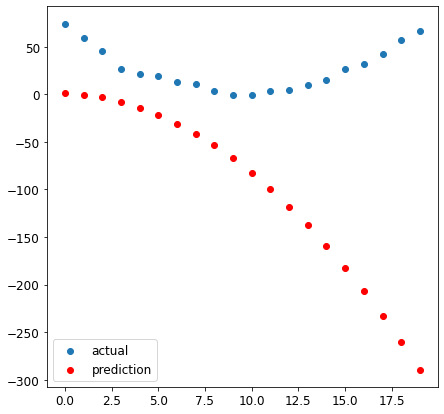

In [44]:
show_preds(preds)

###### Loss

In [45]:
loss = mse(speed, preds)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

###### Gradients

In [46]:
loss.backward()
params.grad

tensor([-53195.8594,  -3419.7146,   -253.8908])

###### Step

In [47]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [48]:
preds = f(time, params)
mse(speed, preds)

tensor(5435.5366, grad_fn=<MeanBackward0>)

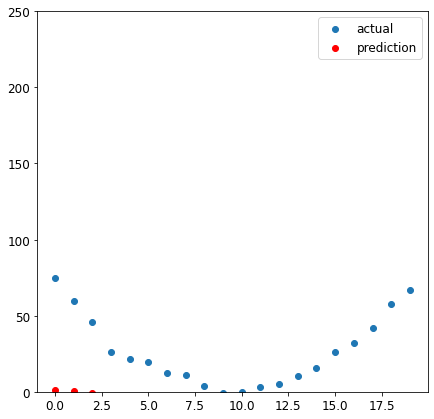

In [49]:
fig, ax = plt.subplots(figsize=(7,7))

show_preds(preds, ax=ax)
ax.set_ylim([0, 250])

plt.show()

In [50]:
def apply_step(params, verbose=True):
    params.grad = None
    
    preds = f(time, params)
    loss = mse(speed, preds)
    loss.backward()
    params.data -= lr*params.grad
    
    if verbose: print(loss.item())
    
    return preds

In [51]:
for _ in range(10): apply_step(params)

5435.53662109375
1577.4495849609375
847.3780517578125
709.22265625
683.0757446289062
678.12451171875
677.1839599609375
677.0025024414062
676.96435546875
676.9537353515625


676.9481201171875


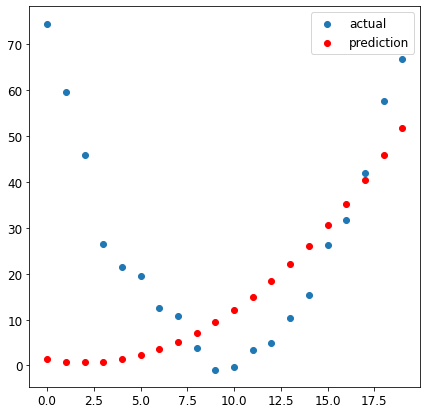

In [52]:
show_preds(apply_step(params))

### Apply to MNIST

###### Independent variable

In [53]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

###### Label

In [54]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(-1)
train_y.shape

torch.Size([12396, 1])

###### Dataset

In [55]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

###### Valid

In [56]:
valid_x = torch.cat([valid_stacked_threes, valid_stacked_sevens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_threes) + [0]*len(valid_sevens)).unsqueeze(-1)
valid_ds = list(zip(valid_x, valid_y))

valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

###### The model

The model will be of the form:
$$y = w*x + bias$$

where $x$ is the flattened pixel vector.

In [57]:
def init_params(size, std=1.):
    return (torch.randn(size)*std).requires_grad_()

In [58]:
weights = init_params((28*28,1))
bias = init_params(1)

In [59]:
(train_x[0] * weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

In [60]:
def linear1(xb):
    return xb@weights + bias

In [61]:
preds = linear1(train_x)
preds.shape

torch.Size([12396, 1])

Interpret preds as:
- below $0$ -> 3
- above $0$ -> 7

In [62]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [63]:
corrects.float().mean().item()

0.4912068545818329

### Building a loss function

In [64]:
targets = tensor([1, 0, 1])
preds = tensor([.9, .4, .2])

In [65]:
# torch.where(a,b,c) --> if a then b else c
torch.where(targets==1, 1-preds, preds)

tensor([0.1000, 0.4000, 0.8000])

In [106]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

This loss function assumes that the predictions are always between 0 and 1, so let's introduce sigmoid

In [107]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [108]:
sigmoid(preds)

tensor([[0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [3.1919e-14],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [3.8665e-23],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [3.2680e-24],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [4.7761e-27],
        [1.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0

In [69]:
sigmoid(preds)==torch.sigmoid(preds)

tensor([True, True, True])

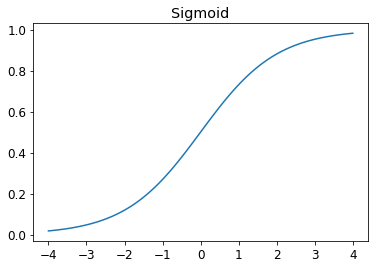

In [70]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

### Mini-Batches

DataLoaders are a pytorch construct that handles the (random) batching of data.

In [71]:
numbers = range(15)
dl = DataLoader(numbers, bs=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

A bit more realistic: data with labels:

In [75]:
chars = L(enumerate(string.ascii_lowercase))
chars

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [77]:
char_dl = DataLoader(chars, bs=6, shuffle=True)
list(char_dl)

[(tensor([19, 14,  0, 24, 20, 12]), ('t', 'o', 'a', 'y', 'u', 'm')),
 (tensor([23,  8,  9,  3, 16,  6]), ('x', 'i', 'j', 'd', 'q', 'g')),
 (tensor([ 4,  7,  1, 13,  2, 22]), ('e', 'h', 'b', 'n', 'c', 'w')),
 (tensor([ 5, 17, 18, 10, 11, 15]), ('f', 'r', 's', 'k', 'l', 'p')),
 (tensor([25, 21]), ('z', 'v'))]

### Putting it all together

In [109]:
class LinearModel:
    def __init__(self, weights, bias):
        self.weights = weights
        self.bias = bias
        
    def __call__(self, xb):
        return xb@self.weights + self.bias
    
    def reset_gradients(self):
        self.weights.grad.zero_()
        self.bias.grad.zero_()
        
    def update_params(self, lr):
        self.weights.data -= self.weights.grad * lr
        self.bias.data -= self.bias.grad * lr
        self.reset_gradients()

In [110]:
weights = init_params((28*28,1))
bias = init_params(1)
model = LinearModel(weights, bias)
lr = 1.

dl = DataLoader(dset, bs=256)
valid_dl = DataLoader(valid_ds, bs=256)

In [111]:
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [114]:
def train_one_epoch():
    for xb, yb in dl:
        preds = model(xb)
        loss = mnist_loss(preds, yb)

        loss.backward()
        model.update_params(lr)

In [118]:
def batch_accuracy(xb, yb):
    preds = model(xb).sigmoid()
    return ((preds>0.5)==yb).float().mean()

In [129]:
def validate_epoch():
    batch_accs = [batch_accuracy(xb, yb) for xb, yb in valid_dl]
    return torch.stack(batch_accs).mean()

In [132]:
validate_epoch()

tensor(0.9780)

In [134]:
weights = init_params((28*28,1))
bias = init_params(1)
model = LinearModel(weights, bias)
lr = 1.

dl = DataLoader(dset, bs=256)
valid_dl = DataLoader(valid_ds, bs=256)

In [135]:
for _ in range(20):
    train_one_epoch()
    print(validate_epoch())

tensor(0.6151)
tensor(0.8012)
tensor(0.8803)
tensor(0.9189)
tensor(0.9350)
tensor(0.9477)
tensor(0.9530)
tensor(0.9579)
tensor(0.9594)
tensor(0.9628)
tensor(0.9643)
tensor(0.9652)
tensor(0.9662)
tensor(0.9682)
tensor(0.9691)
tensor(0.9696)
tensor(0.9701)
tensor(0.9706)
tensor(0.9716)
tensor(0.9721)
